In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import re
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
from IPython.display import display, HTML, clear_output, Image
import pandas as pd
from itertools import product
import math
from deepdiff import DeepDiff

In [3]:
# Styling notebook
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML("<style>" + styles + "</style")

css_styling()

In [4]:
sys.path.insert(1, "/workspaces/ou-af/problem2/")

In [5]:
# import de code
import src.oopnclasses as oopnclasses
import src.oopnbuilder as oopnbuilder
import src.diagrambuilder as diagrambuilder
import src.testobservereplace as testchangeinput
import src.testchangeinput as testobservereplace
import specs.components as componentspecs
import specs.connections as connectionspecs
import specs.assemblies as assemblyspecs
import specs.tests as testspecs

In [6]:
def visualizeStructure(diagram):
#    display(HTML("<style>.container { width:100% !important; }</style>"))

    # print summary of nodes
    print(diagram)

    # view structure
    gnb.showInfluenceDiagram(diagram, size=60)
    
def createUtilityRow(nodelist):
    row_elements = [diagram.utility(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def createCptRow(nodelist):
    row_elements = [diagram.cpt(node) for node in nodelist]
    gnb.flow.row(*row_elements)

def showCPTs(diagram):
    nodes = diagram.nodes()
    for n in nodes:
        if(diagram.isChanceNode(n)):
            gnb.flow.row(diagram.cpt(n))
            
def getDiagramChanceNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isChanceNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printCptTables(diagram, system):
    for component in system.getComponents():
        print("CPT tables for component: " + component.getName())
        createCptRow(getDiagramChanceNodeIdsForComponent(component.getName(), diagram))
        
def getDiagramUtilityNodeIdsForComponent(componentname, diagram):
    idlist = []
    diagramNames = diagram.names()
    for dname in diagramNames:
        if(re.search(componentname + "$", dname)):
            nodeid = diagram.idFromName(dname)
            if (diagram.isUtilityNode(nodeid)):
                idlist.append(nodeid)
    return idlist
    

def printUtilityTables(diagram, system):
    for component in system.getComponents():
        print("Utility tables for component: " + component.getName())
        createUtilityRow(getDiagramUtilityNodeIdsForComponent(component.getName(), diagram))

## Type 2 test:
- voorbeeld systeem met meerdere switches (0, 1, 2), meerdere lampjes (0, 1, 2) en meerdere wires (0, 1, 2, 3, 4, 5)
- voor een deel van de keten zijn er 2 sets aan evidence bijvoorbeeld EnabledStateInputsSwitch:0 / PresentLightOutputsLight2 en EnabledStateInputsSwitch:1 / PresentLightOutputsLight2
    - eis is dat startpunt van de keten een input is en eindpunt een outputnode
    - van een keten in het systeem zijn het beginpunt en het eindpunt bekend, niet de tussenliggende nodes, die moeten dan berekend worden
- indien 2 sets aan evidence worden geconstateerd is dat signaal dat de test is uitgevoerd en dan gaan we terug naar informatiemodel
- mbv informatiemodel berekenen we pad van begin tot einde van de keten via shortest pad methode 
  - wat als er meerdere paden zijn?
- het pad wordt gekopieerd en toegevoegd aan het diagram
  - alleen de nodes die in het pad zitten worden gekopieerd naar een nieuw component
    - output nodes worden dan altijd gekopieerd
  - nodes niet in het pad maar wel in te kopieren component worden hergebruikt uit het originele systeem
    - health nodes worden altijd hergebruikt
  - output van een gekopieerde component wordt verbonden met de health van de oorspronkelijke component
  - een connectienode wordt verbonden met de health van de connectie (todo)

- het extra pad wordt vastgehouden zodat bij inference de extra evidence aan dit pad kan worden verbonden



In [29]:
# gather specs for a system
# system = light + replacedecision + test
components = [componentspecs.light, componentspecs.switch]
connections = [connectionspecs.wire, connectionspecs.wire2]
tests = [testspecs.observeorreplacetest, testspecs.changeinputtest]
assembly = {
    "components"  : components,
    "connections" : connections,
    "structure"   : assemblyspecs.structure1,   # light, switch, wire but multiple times
    "tests"       : tests,
    "testmapping" : testspecs.testmappinglight     # 1 test type 2
}

In [30]:
# fill information model with network classes based on descriptions
oopn = oopnbuilder.OopnBuilder(assembly).getOopn()

start building system: structure1
number of components: 2
number of connections: 1
number of tests: 1


In [31]:
# create diagram object
diagram = gum.InfluenceDiagram()
diagram = diagrambuilder.diagramBuilder(diagram, oopn)

adding component: Light
adding component: Switch
adding connection between: PresentPowerOutputsSwitch and: PresentPowerInputsLight
adding cpt for component: Light
adding cpt for component: Switch
adding cpt for connection: Wire
adding test: ObserveOrReplaceTest
adding node: DecisionObserveOrReplaceTestLight
adding node: UtilityObserveOrReplaceTestLight
adding node: TestOutcomeObserveOrReplaceTestLight
adding node: DecisionReplaceLight
adding node: UtilityReplaceLight
add edge from: DecisionObserveOrReplaceTestLight to: UtilityObserveOrReplaceTestLight
add edge from: DecisionObserveOrReplaceTestLight to: TestOutcomeObserveOrReplaceTestLight
add edge from: TestOutcomeObserveOrReplaceTestLight to: DecisionReplaceLight
add edge from: DecisionReplaceLight to: UtilityReplaceLight
add edge from: healthLight to: TestOutcomeObserveOrReplaceTestLight
add edge from: healthLight to: UtilityReplaceLight
adding utility to: UtilityObserveOrReplaceTestLight
adding cpt to: TestOutcomeObserveOrReplaceTe

In [32]:
oopn.copyPathType2Test('PresentPowerInputsSwitch', 'PresentLightOutputsLight')

# todo verplaatsen naar testchangeinput.py

adding component: Switchcopy
adding component: Lightcopy
adding connection Wirecopy between: Switchcopy and Lightcopy with healthnode: healthWire


In [33]:
# create diagram object
diagram2 = gum.InfluenceDiagram()

In [34]:
diagram2 = diagrambuilder.diagramBuilder(diagram2, oopn)

adding component: Light
adding component: Switch
adding component: Switchcopy
node not added, already exists in diagramEnabledStateInputsSwitch
node not added, already exists in diagramhealthSwitch
adding component: Lightcopy
node not added, already exists in diagramhealthLight
adding connection between: PresentPowerOutputsSwitch and: PresentPowerInputsLight
adding connection between: PresentPowerOutputsSwitchcopy and: PresentPowerInputsLightcopy
node not added, already exists in diagramhealthWire
adding cpt for component: Light
adding cpt for component: Switch
adding cpt for component: Switchcopy
adding cpt for component: Lightcopy
adding cpt for connection: Wire
adding cpt for connection: Wirecopy
adding test: ObserveOrReplaceTest
adding node: DecisionObserveOrReplaceTestLight
adding node: UtilityObserveOrReplaceTestLight
adding node: TestOutcomeObserveOrReplaceTestLight
adding node: DecisionReplaceLight
adding node: UtilityReplaceLight
add edge from: DecisionObserveOrReplaceTestLigh

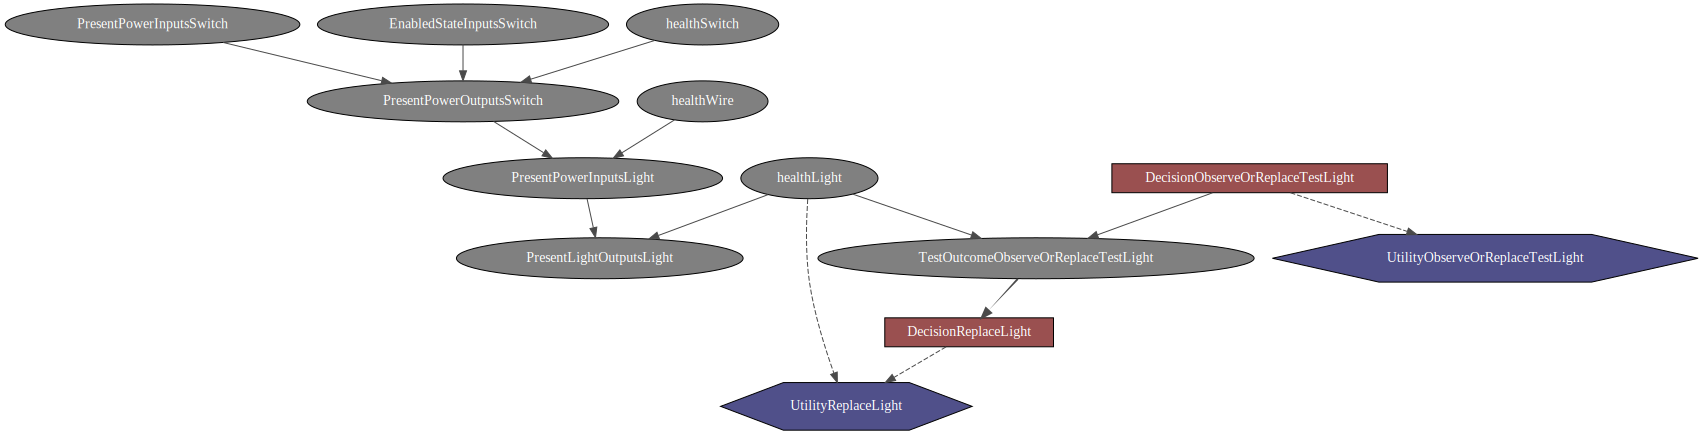

In [35]:
gnb.showInfluenceDiagram(diagram, size=60)

In [49]:
printCptTables(diagram, oopn)

CPT tables for component: Light


CPT tables for component: Switch


CPT tables for component: Switchcopy


CPT tables for component: Lightcopy


In [118]:
diagram.cpt(diagram.idFromName("healthSwitch"))[0] = 0.9
diagram.cpt(diagram.idFromName("healthSwitch"))[1] = 0.1
diagram.cpt(diagram.idFromName("healthSwitch"))
diagram2.cpt(diagram2.idFromName("healthSwitch"))[0] = 0.9
diagram2.cpt(diagram2.idFromName("healthSwitch"))[1] = 0.1
diagram2.cpt(diagram2.idFromName("healthSwitch"))

(pyAgrum.Potential<double>@0x3f0495f0) 
  healthSwitch     |
ok       |broken   |
---------|---------|
 0.9000  | 0.1000  |

In [85]:
diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy"))[{"healthLight":"ok", "PresentPowerInputsLightcopy":"yes"}] = [0.99, 0.01]      # yes, no
diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy"))[{"healthLight":"broken", "PresentPowerInputsLightcopy":"yes"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy"))[{"healthLight":"ok", "PresentPowerInputsLightcopy":"no"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy"))[{"healthLight":"broken", "PresentPowerInputsLightcopy":"no"}] = [0.01, 0.99]

diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"yes", "healthSwitch":"ok", "EnabledStateInputsSwitch":"yes"}] = [0.99, 0.01]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"yes", "healthSwitch":"ok", "EnabledStateInputsSwitch":"no"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"yes", "healthSwitch":"broken", "EnabledStateInputsSwitch":"yes"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"yes", "healthSwitch":"broken", "EnabledStateInputsSwitch":"no"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"no", "healthSwitch":"ok", "EnabledStateInputsSwitch":"yes"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"no", "healthSwitch":"ok", "EnabledStateInputsSwitch":"no"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"no", "healthSwitch":"broken", "EnabledStateInputsSwitch":"yes"}] = [0.01, 0.99]
diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy"))[{"PresentPowerInputsSwitchcopy":"no", "healthSwitch":"broken", "EnabledStateInputsSwitch":"no"}] = [0.01, 0.99]



In [86]:
gnb.flow.row(diagram2.cpt(diagram2.idFromName("PresentLightOutputsLightcopy")), diagram2.cpt(diagram2.idFromName("PresentPowerInputsLightcopy")), diagram2.cpt(diagram2.idFromName("PresentPowerOutputsSwitchcopy")), diagram2.cpt(diagram2.idFromName("PresentPowerInputsSwitchcopy")) )

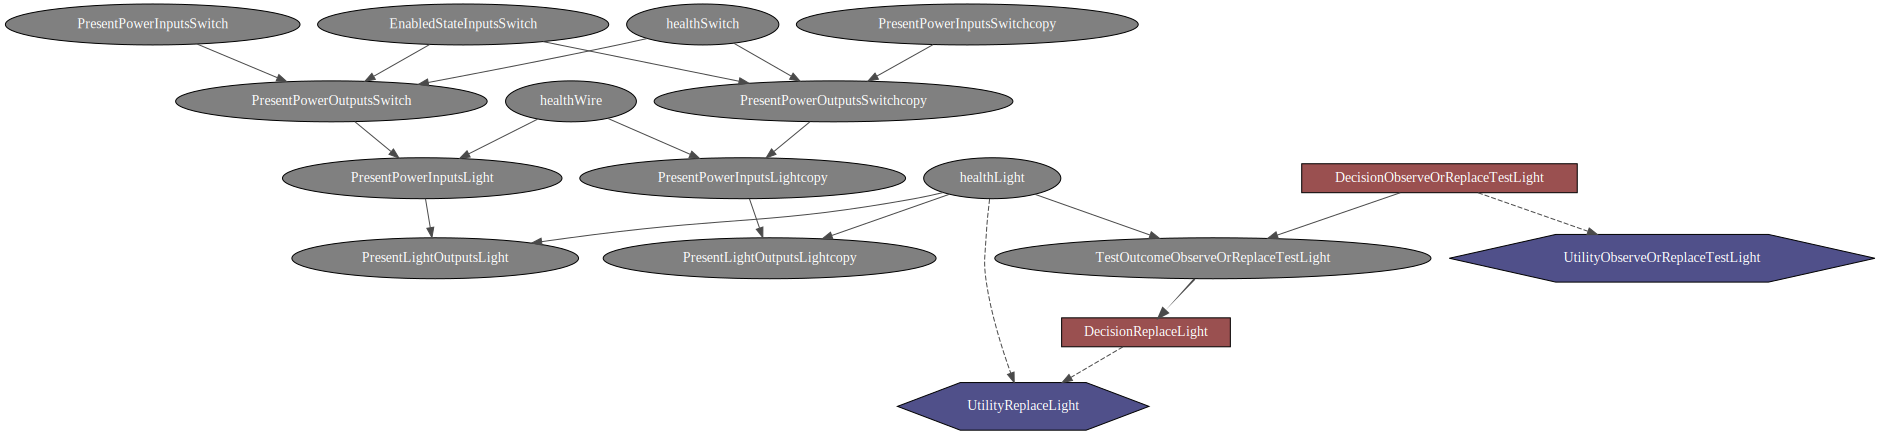

In [77]:
gnb.showInfluenceDiagram(diagram2, size=60)

In [38]:
printCptTables(diagram2, oopn)

CPT tables for component: Light


NotFound: [pyAgrum] Object not found: No element with the key <14>

In [119]:
evs = {    
'PresentPowerInputsSwitch':0,
'EnabledStateInputsSwitch':0,

'PresentLightOutputsLight':1,
#'PresentPowerInputsLight',
#'healthLight',
#'PresentPowerOutputsSwitch',
#'healthSwitch',
#'PresentLightOutputsLight1',
#'PresentPowerInputsLight1':1,
#'healthLight1',
#'PresentPowerOutputsSwitch1',
#'PresentPowerInputsSwitch1',
#'EnabledStateInputsSwitch1',
#'healthSwitch1',
#'PresentLightOutputsLight2':1,
#'PresentPowerInputsLight2',
#'healthLight2',
#'PresentPowerOutputsSwitch2',
#'PresentPowerInputsSwitch2',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight1',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight2',
}
    


In [121]:
evs2 = {    
'PresentPowerInputsSwitch':0,
'EnabledStateInputsSwitch':0,

'PresentLightOutputsLight':1,
#'PresentPowerInputsLight',
#'healthLight',
#'PresentPowerOutputsSwitch',
#'healthSwitch',
#'PresentLightOutputsLight1',
#'PresentPowerInputsLight1':1,
#'healthLight1',
#'PresentPowerOutputsSwitch1',
#'PresentPowerInputsSwitch1',
#'EnabledStateInputsSwitch1',
#'healthSwitch1',
#'PresentLightOutputsLight2':1,
#'PresentPowerInputsLight2',
#'healthLight2',
#'PresentPowerOutputsSwitch2',
#'PresentPowerInputsSwitch2',
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'healthLight1',
#'PresentLightOutputsLight1copy':0,
#'PresentPowerInputsLight1copy':0,
#'EnabledStateInputsSwitch2',
#'healthSwitch2',
#'PresentPowerOutputsSwitch2copy',
'PresentPowerInputsSwitchcopy':1,
#'healthLight2',
'PresentLightOutputsLightcopy':0,
#'PresentPowerInputsLight2copy':1
}

In [120]:
ie = gum.ShaferShenoyLIMIDInference(diagram) 
ie.setEvidence(evs)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram,engine=ie, evs=evs, size=200))

In [122]:
ie2 = gum.ShaferShenoyLIMIDInference(diagram2) 
ie2.setEvidence(evs2)
#ie.addNoForgettingAssumption(["DecisionTestObserveHealthSwitch","DecisionReplaceSwitch", "DecisionTestObserveHealthLight", "DecisionReplaceLight"])
gnb.sideBySide(gnb.getInference(diagram2,engine=ie2, evs=evs2, size=200))

In [ ]:
# visualiseren additionele DAG 
import matplotlib.pyplot as plt
subax1 = plt.subplot()
#nx.draw(G, with_labels=True, font_color='white', node_size=2000)
nx.draw(G, font_color='white', node_size=500)

In [ ]:
# outputtest
testutility = diagram.addUtilityNode(gum.LabelizedVariable("outputTest", "outputTest", 1))
testdecision = diagram.addDecisionNode(gum.LabelizedVariable("testdecision", "testdecisionl", ["yes", "no"]))
testoutcome = diagram.addChanceNode(gum.LabelizedVariable("testoutcome", "testoutcome", ["ok", "problem", "notdone"]))
diagram.addArc(diagram.idFromName("PresentLightOutputsLight"), testutility)
diagram.addArc(testdecision, testutility)
diagram.addArc(testdecision, testoutcome)
diagram.addArc(diagram.idFromName("healthWire"), testoutcome)
diagram.addArc(diagram.idFromName("healthSwitch"), testoutcome)
diagram.addArc(diagram.idFromName("healthLight"), testoutcome)

In [ ]:
printCptTables(diagram, oopn)

In [ ]:
printUtilityTables(diagram, oopn)

In [ ]:
diagram.utility("outputTest")[{"testdecision":"yes", "PresentLightOutputsLight":"no"}] = 4
diagram.utility("outputTest")[{"testdecision":"no", "PresentLightOutputsLight":"no"}] = 3
diagram.utility("outputTest")[{"testdecision":"yes", "PresentLightOutputsLight":"yes"}] = 2
diagram.utility("outputTest")[{"testdecision":"no", "PresentLightOutputsLight":"yes"}] = 1
diagram.utility("outputTest")

In [ ]:
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"ok","testdecision":"yes" }] = [0.98, 0.01, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"ok", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"ok", "healthSwitch":"broken", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"ok", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]

diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"ok","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"ok","testdecision":"no" }] = [0.01, 0.01, 0.98]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"broken","testdecision":"yes" }] = [0.01, 0.98, 0.01]
diagram.cpt(diagram.idFromName("testoutcome"))[{"healthLight":"broken", "healthSwitch":"broken", "healthWire":"broken","testdecision":"no" }] = [0.01, 0.01, 0.98]


In [ ]:
diagram.cpt(diagram.idFromName("testoutcome"))

In [ ]:
diagram.cpt.posterior("outputTest")

In [ ]:
ie.posteriorUtility("UtilityReplaceWire")

In [ ]:
a = -5*.0087 + -2*.0013
b = 0 + -4* .1238
print(a+b)

In [ ]:
gnb.showInfluenceDiagram(diagram, size=60)

In [ ]:
from collections import defaultdict, deque

# Class to represent a graph using adjacency list


class Graph:
    def __init__(self):
        self.adjList = defaultdict(list)

    # Function to add an edge to the graph
    def addEdge(self, u, v):
        self.adjList[u].append(v)

    # Function to perform Breadth First Search on a graph represented using adjacency list
    def bfs(self, startNode):
        # Create a queue for BFS
        queue = deque()
        visited = [False] * (max(self.adjList.keys()) + 1)

        # Mark the current node as visited and enqueue it
        visited[startNode] = True
        queue.append(startNode)

        # Iterate over the queue
        while queue:
            # Dequeue a vertex from queue and print it
            currentNode = queue.popleft()
            print(currentNode, end=" ")

            # Get all adjacent vertices of the dequeued vertex currentNode
            # If an adjacent has not been visited, then mark it visited and enqueue it
            for neighbor in self.adjList[currentNode]:
                if not visited[neighbor]:
                    visited[neighbor] = True
                    queue.append(neighbor)


# Create a graph
graph = Graph()

# Add edges to the graph
graph.addEdge(0, 1)
graph.addEdge(0, 2)
graph.addEdge(1, 3)
graph.addEdge(1, 4)
graph.addEdge(2, 4)

# Perform BFS traversal starting from vertex 0
print("Breadth First Traversal starting from vertex 0:", end=" ")
graph.bfs(0)


In [ ]:
import networkx as nx

G = nx.DiGraph()
G.add_nodes_from(range(100, 105))
G.add_edges_from([(100, 101), (100, 103), (101,104), (103,102)])


In [ ]:
import matplotlib.pyplot as plt
subax1 = plt.subplot()
nx.draw(G, with_labels=True, font_weight='bold', font_color='white', node_size=1000)


In [ ]:
nx.has_path(G, 100, 104)

In [ ]:
nx.shortest_path(G, 100, 104)

In [ ]:
nx.has_path(G, 100, 104)
nx.shortest_path(G, 100, 104)